In [7]:
import torch

In [8]:
from utils import assign_splits, get_label_mapping

# assign_splits(
#     file_path="faces_yolo_metadata.csv",
#     id_column="id",
#     label_column="mbti",
# )

mbti_to_idx = get_label_mapping(
    file_path="faces_yolo_id_split_metadata.csv",
    label_column="mbti",
)

# for key in mbti_to_idx:
#     if key.startswith("I"):
#         mbti_to_idx[key] = 0
#     else: 
#         mbti_to_idx[key] = 1

print("MBTI to index mapping:", mbti_to_idx)

MBTI to index mapping: {'ENFJ': 0, 'ENFP': 1, 'ENTJ': 2, 'ENTP': 3, 'ESFJ': 4, 'ESFP': 5, 'ESTJ': 6, 'ESTP': 7, 'INFJ': 8, 'INFP': 9, 'INTJ': 10, 'INTP': 11, 'ISFJ': 12, 'ISFP': 13, 'ISTJ': 14, 'ISTP': 15}


In [9]:
from torchvision import transforms

train_tf = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(0.25, 0.25, 0.25, 0.05)], p=0.8),
        transforms.RandomApply(
            [
                transforms.RandomAffine(
                    degrees=10,  # small rotation
                    translate=(0.05, 0.05),  # small shifts
                    scale=(0.9, 1.1),
                )
            ],
            p=0.5,
        ),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
        transforms.ToTensor(),
        transforms.RandomErasing(
            p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3), value="random"
        ),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

val_tf = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [10]:
from torch.utils.data import DataLoader
from dataset import IDSplitCelebMBTIDataset

train_ds = IDSplitCelebMBTIDataset(
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    split="train",
    mbti_to_idx=mbti_to_idx,
    transform=train_tf,
)

val_ds = IDSplitCelebMBTIDataset(
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    mbti_to_idx=mbti_to_idx,
    split="val",
    transform=val_tf,
)

test_ds = IDSplitCelebMBTIDataset(
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    mbti_to_idx=mbti_to_idx,
    split="test",
    transform=val_tf,
)

print(len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)

for images, labels in train_loader:
    print(images.shape)  # [Batch, 3, 224, 224]
    print(labels.shape)  # [Batch, 4]
    break

9573 1201 1205
torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
from models import MBTISingleHeadMulticlass
import torch.nn as nn
from tqdm import tqdm

num_classes = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MBTISingleHeadMulticlass(freeze_backbone=True, num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [12]:
# train on frozen backbone for a few epochs
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-2)

for epoch in range(1, 9):
    # training phase with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)

        # print(logits.shape, y.shape)  # Debugging line
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total_loss += loss.item() * y.size(0)
        total += y.size(0)

        pbar.set_postfix(loss=loss.item())

    tr_loss = total_loss / total
    tr_acc = total_correct / total

    # validation phase with tqdm
    pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            preds = logits.argmax(1)
            total_correct += (preds == y).sum().item()
            total_loss += loss.item() * y.size(0)
            total += y.size(0)

            pbar.set_postfix(loss=loss.item())

    va_loss = total_loss / total
    va_acc = total_correct / total

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f}/ train accuracy {tr_acc:.3f} | "
        f"val loss {va_loss:.4f}/ val accuracy {va_acc:.3f}"
    )

Epoch 01 | train loss 2.8778/ train accuracy 0.066 | val loss 2.7769/ val accuracy 0.087


Epoch 02 | train loss 2.8066/ train accuracy 0.089 | val loss 2.7630/ val accuracy 0.087


Epoch 03 | train loss 2.7786/ train accuracy 0.096 | val loss 2.7456/ val accuracy 0.084


Epoch 04 | train loss 2.7611/ train accuracy 0.101 | val loss 2.7441/ val accuracy 0.082


Epoch 05 | train loss 2.7457/ train accuracy 0.108 | val loss 2.7379/ val accuracy 0.092


Epoch 06 | train loss 2.7295/ train accuracy 0.110 | val loss 2.7348/ val accuracy 0.092


Epoch 07 | train loss 2.7195/ train accuracy 0.118 | val loss 2.7333/ val accuracy 0.087


Epoch 08 | train loss 2.7066/ train accuracy 0.118 | val loss 2.7343/ val accuracy 0.087


In [13]:

# unfreeze backbone
for param in model.backbone.parameters():
    param.requires_grad = True

train_accs = []
val_accs = []
train_losses = []
val_losses = []

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
for epoch in range(50):
    # training phase with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)

        # print(logits.shape, y.shape)  # Debugging line
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total_loss += loss.item() * y.size(0)
        total += y.size(0)

        pbar.set_postfix(loss=loss.item())

    tr_loss = total_loss / total
    tr_acc = total_correct / total

    # validation phase with tqdm
    pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            preds = logits.argmax(1)
            total_correct += (preds == y).sum().item()
            total_loss += loss.item() * y.size(0)
            total += y.size(0)

            pbar.set_postfix(loss=loss.item())

    va_loss = total_loss / total
    va_acc = total_correct / total

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f}/ train accuracy {tr_acc:.3f} | "
        f"val loss {va_loss:.4f}/ val accuracy {va_acc:.3f}"
    )

Epoch 00 [train]:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 00 | train loss 2.6895/ train accuracy 0.132 | val loss 2.7251/ val accuracy 0.092


Epoch 01 | train loss 2.6733/ train accuracy 0.143 | val loss 2.7230/ val accuracy 0.096


Epoch 02 | train loss 2.6566/ train accuracy 0.143 | val loss 2.7213/ val accuracy 0.092


Epoch 03 | train loss 2.6297/ train accuracy 0.156 | val loss 2.7193/ val accuracy 0.102


Epoch 04 | train loss 2.6069/ train accuracy 0.173 | val loss 2.7209/ val accuracy 0.112


Epoch 05 | train loss 2.5935/ train accuracy 0.175 | val loss 2.7168/ val accuracy 0.097


Epoch 06 | train loss 2.5775/ train accuracy 0.188 | val loss 2.7222/ val accuracy 0.104


Epoch 07 | train loss 2.5535/ train accuracy 0.194 | val loss 2.7239/ val accuracy 0.104


Epoch 08 | train loss 2.5356/ train accuracy 0.199 | val loss 2.7263/ val accuracy 0.108


Epoch 09 | train loss 2.5172/ train accuracy 0.214 | val loss 2.7323/ val accuracy 0.105


Epoch 10 | train loss 2.4952/ train accuracy 0.224 | val loss 2.7296/ val accuracy 0.105


Epoch 11 | train loss 2.4693/ train accuracy 0.241 | val loss 2.7291/ val accuracy 0.107


Epoch 12 | train loss 2.4570/ train accuracy 0.250 | val loss 2.7352/ val accuracy 0.104


KeyboardInterrupt: 

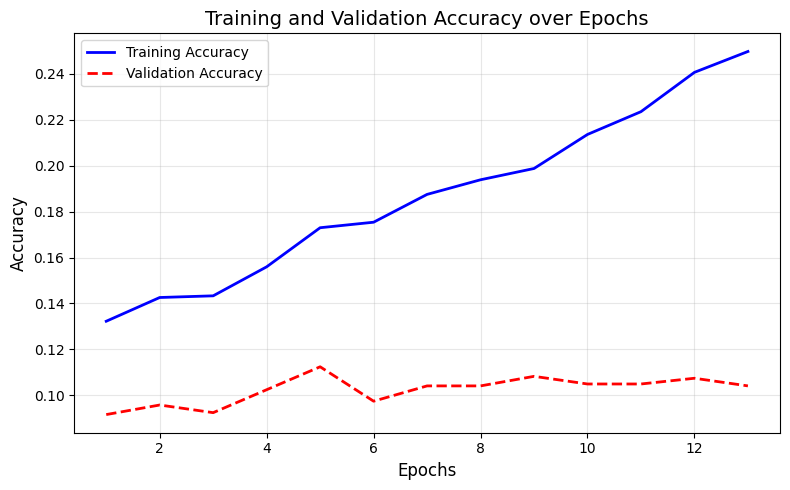

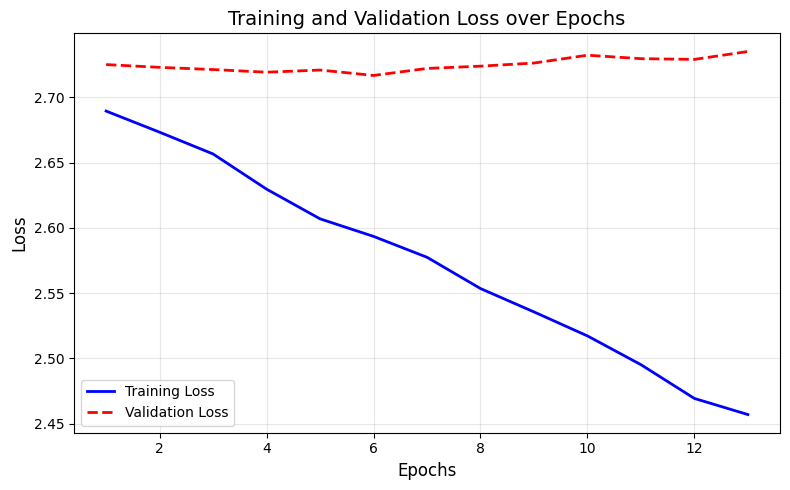

In [14]:
import matplotlib.pyplot as plt
from utils import plot_metric, plot_confusion_matrix

plot_metric(
    train_values=train_accs,
    val_values=val_accs,
    title="Training and Validation Accuracy over Epochs",
    ylabel="Accuracy",
)

plot_metric(
    train_values=train_losses,
    val_values=val_losses,
    title="Training and Validation Loss over Epochs",
    ylabel="Loss",
)

Generating predictions for Confusion Matrix...


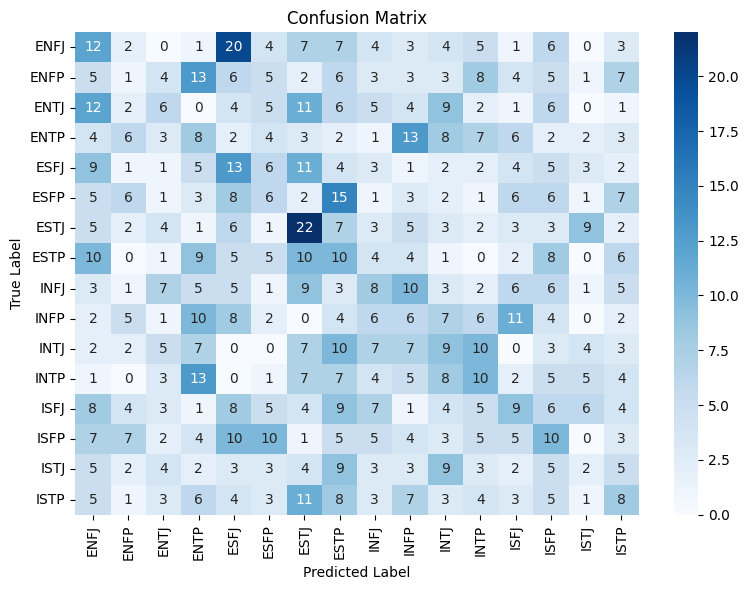


--- Per-Class Accuracy ---
ENFJ: 15.19%
ENFP: 1.32%
ENTJ: 8.11%
ENTP: 10.81%
ESFJ: 18.06%
ESFP: 8.22%
ESTJ: 28.21%
ESTP: 13.33%
INFJ: 10.67%
INFP: 8.11%
INTJ: 11.84%
INTP: 13.33%
ISFJ: 10.71%
ISFP: 12.35%
ISTJ: 3.12%
ISTP: 10.67%


In [15]:
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

plot_confusion_matrix(
    model=model,
    loader=test_dl,
    device=device,
    class_names=list(mbti_to_idx.keys())
)

In [16]:
torch.save(model.state_dict(), "resnet_mbti_classification.pth")